# DPO

- RLHF and DPO are methods that can be used to teach the LLM to prefer one answer style over the other, that is, aligning better with user preferences
- The RLHF process, which requires training a separate reward model, is outlined below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/4.webp" width=600px>

- Compared to RLHF, DPO aims to simplify the process by **optimizing models directly for user preferences without the need for complex reward modeling** and **policy optimization**
- In other words, DPO focuses on directly optimizing the model's output to align with human preferences or specific objectives
- Shown below is the main idea as an overview of how DPO works

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/5.webp?123" width=600px>

- The concrete equation to implement the DPO loss is shown below; we will revisit the equation when we implement it in Python further down in this code notebook

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=600px>

&nbsp;
# 2) Preparing a preference dataset for DPO

- Here, we work with a dataset that contains more polite and less polite responses to instruction prompts (concrete examples are shown in the next section)

- The dataset was generated via the [create-preference-data-ollama.ipynb](create-preference-data-ollama.ipynb) notebook

In [1]:
import json


file_path = "/home/david/Documents/data_science/datasets/instruction-finetuning/instruction-data-with-preference.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [3]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}


#### Alpaca Prompting

In [4]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


In [6]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [7]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


&nbsp;
## 2.2) Creating training, validation, and test splits

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))


Training set length: 935
Validation set length: 55
Test set length: 110


&nbsp;
## 2.3) Developing a `PreferenceDataset` class and batch processing function

In [10]:
import torch
from torch.utils.data import Dataset


class PreferenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            prompt = format_input(entry)
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            prompt_tokens = tokenizer.encode(prompt)
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            self.encoded_texts.append({
                "prompt": prompt_tokens,
                "chosen": chosen_full_tokens,
                "rejected": rejected_full_tokens,
            })

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


- Along with an updated `PreferenceDataset` class, we also need an updated batch collation function that we use to pad the sequences in each batch to an equal length so that we can assemble them in batches

In [11]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    # Initialize lists to hold batch data
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []

    }

    # Determine the longest sequence to set a common padding length
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            current_max = max(len(item[key])+1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # Process each item in the batch
    for item in batch:
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        for key in ["chosen", "rejected"]:
            # Adjust padding according to the common maximum length
            sequence = item[key]
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            mask = torch.ones(len(padded)).bool()

            # Set mask for all padding tokens to False
            mask[len(sequence):] = False

            # Set mask for all input tokens to False
            # +2 sets the 2 newline ("\n") tokens before "### Response" to False
            if mask_prompt_tokens:
                mask[:prompt.shape[0]+2] = False

            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # Final processing
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # Stack all sequences into a tensor for the given key
        tensor_stack = torch.stack(batch_data[key])

        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # Move to the specified device
        batch_data[key] = tensor_stack.to(device)

    return batch_data

Let's inspect this collator

In [12]:
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,            # Put the data directly on a GPU if available
    mask_prompt_tokens=True,  # This is optional
    allowed_max_length=1024   # The supported context length of the model
)

Device: cuda


In [13]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


In [14]:
example_data

[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
  'input': 'freind --> friend',
  'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".',
  'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".',
  'chosen': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'},
 {'instruction': 'Edit the following sentence for grammar.',
  'input': 'He go to the park every day.',
  'output': 'He goes to the park every day.',
  'rejected': 'He goes to the stupid park every single day.',
  'chosen': 'He goes to the park every day.'}]

## DataLoader

- Next, let's instantiate an `example_dataset` and use a PyTorch `DataLoader` to create an `example_dataloader` that mimics the data loader we will use for the model training later:

In [15]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

In [16]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


In [17]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- We don't really need the responses for training; what we need to feed to the model during training are the `"chosen"` and `"rejected"` entries

- The  `"chosen"` and `"rejected"` response entries are padded so that we can stack them as tensors; similar to the prompts, these response texts are encoded into token IDs:

In [18]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

In [19]:
batch["rejected"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318,  6228,   503,  2642,    11,   651,
           340,  1978,    11,   262,  3376, 24993,   318,   366,  6726,  1911,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

In [20]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # [0] for the first entry in the batch
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


In [22]:
text_chosen = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text_chosen)
print("-------------------------------------------------------------------------------------------------------")
text_rejected = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text_rejected)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
-------------------------------------------------------------------------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


- Don't worry; the `<|endoftext|>` tokens will be ignored in the loss later so that they won't affect the training outcome

In [23]:
print("chosen inputs:", batch["chosen"][0].shape)
print("chosen mask:  ", batch["chosen_mask"][0].shape)

chosen inputs: torch.Size([81])
chosen mask:   torch.Size([81])


In [24]:
 batch["chosen"][0]

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
          416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
        21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
        21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
          366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
          318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
        50256], device='cuda:0')

In [25]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

### Masking the response for the loss

In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [27]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


&nbsp;
## 2.4) Creating training, validation, and test set data loaders

- Above, we worked with a small example subsets from the preference dataset for illustration purposes
- Let's now create the actual training, validation, and test set data loaders
- This process is identical to creating the data loaders in the pretraining and instruction finetuning chapters and thus should be self-explanatory

In [28]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's iterate through the data loader and take a look at the dataset shapes:

In [29]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

&nbsp;
# 3) Loading a finetuned LLM for DPO alignment

1. LLM alignment steps, such as RLHF or DPO, assume that we already have an instruction-finetuned model

- This section contains minimal code to load the model that was instruction finetuned and saved in chapter 7

In [30]:
from scripts.ch7_previous_chapters import GPTModel
from pathlib import Path

In [31]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
}


In [32]:
CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [33]:
path_pth = Path("ch7-model/gpt2-medium355M-sft.pth") 
model.load_state_dict(
    torch.load(
        path_pth,
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

### Try the model

In [34]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [35]:
from scripts.ch7_previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


In [36]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


## Preparing the two LLMs in DPO

- As mentioned at the beginning of this notebook, DPO works with two LLMs: 
    - a policy model (the LLM that we want to optimize) 
    - a reference model (the original model that we keep unchanged)

In [37]:
device

device(type='cuda')

In [38]:
policy_model = model

reference_model = GPTModel(BASE_CONFIG)
reference_model.load_state_dict(
    torch.load(
        path_pth,
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
reference_model.eval()

policy_model.to(device)
reference_model.to(device);

&nbsp;
# 4) Coding the DPO Loss Function

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/dpo/3.webp?123" width=800px>


- These lines above calculate the difference in log probabilities (logits) for the chosen and rejected samples for both the policy model and the reference model (this is due to $\log\left(\frac{a}{b}\right) = \log a - \log b$):

$$\log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_\theta (y_l \mid x)} \right) \quad \text{and} \quad \log \left( \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$$

- Next, the code `logits = model_logratios - reference_logratios` computes the difference between the model's log ratios and the reference model's log ratios, i.e., 

$$\beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right)$$


- Finally, `losses = -F.logsigmoid(beta * logits)`  calculates the loss using the log-sigmoid function; in the original equation, the term inside the expectation is 

$$\log \sigma \left( \beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right) \right)$$

In [39]:
import torch.nn.functional as F

def compute_dpo_loss(
      model_chosen_logprobs,
      model_rejected_logprobs,
      reference_chosen_logprobs,
      reference_rejected_logprobs,
      beta=0.1,
    ):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
        label_smoothing: conservativeness for DPO loss.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """

    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    # DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

- Above, we assumed that the log probabilities were already computed; let's now define a `compute_logprobs` function that we can use to compute these log probabilities that were passed into the `compute_dpo_loss` function above, that is, the values $\pi_\theta (y_w \mid x)$, ${\pi_\theta (y_l \mid x)}$, and so forth:

In [40]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

In [41]:
# Sample data
logits = torch.tensor(
    [[2.0, 1.0, 0.1],
     [0.5, 2.5, 0.3]])  # Shape: (2, 3)
targets = torch.tensor([0, 2])  # Shape: (2,)

In [42]:
logits.shape

torch.Size([2, 3])

In [43]:
targets.shape

torch.Size([2])

In [44]:
# Manual loss using torch.gather
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)

In [45]:
log_softmax_logits

tensor([[-0.4170, -1.4170, -2.3170],
        [-2.2200, -0.2200, -2.4200]])

In [46]:
selected_log_probs = torch.gather(
    input=log_softmax_logits,
    dim=1,
    index=targets.unsqueeze(1), # Shape 2, 1
).squeeze(1)  # Shape: (2,)

In [47]:
selected_log_probs

tensor([-0.4170, -2.4200])

In [48]:
targets.unsqueeze(1)

tensor([[0],
        [2]])

- We have taken for the first example in the first batch the first logit of the first token (pos. 0 as stated by the first `targets`value which is `-0.417`).
- We have takend for the second example in the batch the logit  in index `2` (pos. 2 as stated by the second `targets`values which is `-2.42`)

In [49]:
manual_loss = -selected_log_probs.mean()  # Averaging over the batch

In [50]:
manual_loss

tensor(1.4185)

In [51]:
# PyTorch loss
cross_entropy_loss = F.cross_entropy(logits, targets)

In [52]:
cross_entropy_loss

tensor(1.4185)

In [53]:
logits.shape

torch.Size([2, 3])

In [54]:
targets.shape

torch.Size([2])

#### Gather

In [55]:
t = torch.tensor(
  [[1., 2.,],
   [3., 4.]]
)

m = torch.tensor(
  [[1, 1],
   [0, 1]]
)

- Above, `t` is a tensor we want to select from, and `m` is a mask to specify how we want to select
 - For instance, since `m` contains `[1, 1]` n the first row, it will select two times the value of `t` in index position `1`, which is the value 2.
 - The second row of `m`, `[0, 1]`, selects index positions 0 and 1 in the second row or `t`, which are `3.` and `4.`

In [56]:
torch.gather(input=t, dim=-1, index=m)

tensor([[2., 2.],
        [3., 4.]])

## Final DPO Loss computation at Batch level

- The `selection_mask` we use there is to optionally ignore prompt and padding tokens

In [57]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    ref_chosen_log_probas = compute_logprobs(
        logits=reference_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    ref_rejected_log_probas = compute_logprobs(
        logits=reference_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

### BREAKING DOWN THE DPO LOSS BATCH

#### a. Batch

In [58]:
import tiktoken
from torch.utils.data import DataLoader

In [59]:
tokenizer = tiktoken.get_encoding("gpt2")

dataset = PreferenceDataset(example_data, tokenizer)

dataloader = DataLoader(
    dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

In [60]:
batch = next(iter(dataloader))

In [61]:
for key in batch.keys():
    # Get the type
    value = batch[key]
    value_type = type(value)

    # If a list of tensors, get the shape of the first tensor
    if isinstance(value, list):
        len_list = len(value)
        value_shape = value[0].shape
        print(f"{key}: {value_type} (len: {len_list}) of {value_shape}")
    else:
        value_shape = value.shape
        print(f"{key}: {value_type} of {value_shape}")


prompt: <class 'list'> (len: 2) of torch.Size([48])
chosen: <class 'torch.Tensor'> of torch.Size([2, 81])
rejected: <class 'torch.Tensor'> of torch.Size([2, 81])
rejected_mask: <class 'torch.Tensor'> of torch.Size([2, 81])
chosen_mask: <class 'torch.Tensor'> of torch.Size([2, 81])


In [62]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

#### b. Forward to get logits

In [63]:
logits = policy_model(batch["chosen"])

Here in the logits we have the logit (not yet prob) for each token, we need the `labels` to specify which is the token in this logits last dimension that corresponds to the actual output token

In [64]:
logits.shape

torch.Size([2, 81, 50257])

Let's get the labels

In [65]:
labels = batch["chosen"]
labels

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

In [66]:
labels.shape

torch.Size([2, 81])

In [67]:
selection_mask = batch["chosen_mask"]
selection_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False

Now let's simulate what happens inside the `compute_logprobs`

In [68]:
labels[0, :4]

tensor([21106,   318,   281, 12064], device='cuda:0')

In [69]:
# Labels are the inputs shifted by one
labels = labels[:, 1:].clone()

In [70]:
labels[0, :4]

tensor([  318,   281, 12064,   326], device='cuda:0')

In [71]:
labels.shape

torch.Size([2, 80])

Since the dimensions don't match because of the shifting we need to also truncate the logits

In [72]:
logits.shape

torch.Size([2, 81, 50257])

In [73]:
# Truncate logits to match the labels num_tokens
logits = logits[:, :-1, :]

In [74]:
logits.shape

torch.Size([2, 80, 50257])

#### c. Compute logprobs of the label tokens

Now we normalize the logits into a probability in the last dimension

In [75]:
log_probs = F.log_softmax(logits, dim=-1)

In [76]:
log_probs.shape

torch.Size([2, 80, 50257])

Now we select accordin to the shifted labels the position of the token in the vocabulary size of the `log_probs` of the token that was actually the next token

In [77]:
labels.shape

torch.Size([2, 80])

First we align the dimensions of `labels` and `log_probs`

In [78]:
labels.unsqueeze(-1).shape

torch.Size([2, 80, 1])

In [79]:
log_probs.shape

torch.Size([2, 80, 50257])

#### d. Token selection based on the next token in the sequence

In [80]:
# Gather the log probabilities for the actual labels
selected_log_probs = torch.gather(
    input=log_probs,
    dim=-1, # or dim = 2
    index=labels.unsqueeze(-1)
).squeeze(-1)

In [81]:
labels[0, :3]

tensor([  318,   281, 12064], device='cuda:0')

In [82]:
torch.set_printoptions(sci_mode=False)

We can get the specific values of the log probs of each token

In [83]:
log_probs[0, 0, 318]

tensor(-0.0002, device='cuda:0', grad_fn=<SelectBackward0>)

In [84]:
log_probs[0, 1, 281]

tensor(-0.0004, device='cuda:0', grad_fn=<SelectBackward0>)

In [85]:
log_probs[0, 2, 12064]

tensor(    -0.0000, device='cuda:0', grad_fn=<SelectBackward0>)

They coincide with the selected ones

In [86]:
selected_log_probs[0, :3]

tensor([    -0.0002,     -0.0004,     -0.0000], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [87]:
selected_log_probs.shape

torch.Size([2, 80])

#### e. Masking to only count the loss to the response tokens

**Mask**: we also shift the selection mask to match the size of the `selected_log_probs`

In [88]:
mask = selection_mask[:, 1:].clone()

In [89]:
selection_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False

In [90]:
# Apply the mask to filter out padding tokens
selected_log_probs = selected_log_probs * mask

In [91]:
selected_log_probs[0]

tensor([    -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,      0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,      0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0000,
            -0.0000,     -0.0000,     -0.0000,     -0.0000,     -0.0001,
            -0.0004,     -0.0001,     -0.0003,     -0.1191,     -0.0229,
            -0.4392,     -0.3107,     -0.0222,     -0.1507,     -1.3676,
            -0.0899,     -0.0003,     -0.0127,     -0.2059,     -0.9238,
            -1.7289,     -0.2144,     -0.8769,     

A log_prob closer to 0 corresponds to a higher probability (closer to 1).

In [92]:
selected_log_probs.shape

torch.Size([2, 80])

In [93]:
avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

#### f. Averaging in the same response all the losses

We have one average log prob of the selected token for each example in the batch.
Basically we have averaged over all the selected tokens the `log_prob`

In [94]:
avg_log_prob

tensor([-0.2876, -0.0103], device='cuda:0', grad_fn=<DivBackward0>)

In [95]:
avg_log_prob.shape

torch.Size([2])

This ends the computation of the `compute_logprobs`

---------------------------------------------

In [96]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Labels are the inputs shifted by one
    labels = labels[:, 1:].clone()

    # Truncate logits to match the labels num_tokens
    logits = logits[:, :-1, :]

    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if selection_mask is not None:
        mask = selection_mask[:, 1:].clone()

        # Apply the mask to filter out padding tokens
        selected_log_probs = selected_log_probs * mask

        # Calculate the average log probability excluding padding tokens
        # This averages over the tokens, so the shape is (batch_size, num_tokens)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        return selected_log_probs.mean(-1)

### compute_dpo_loss

We can now compute the log probas for both the `policy` model and the `reference` model for both the `accepted` and the `rejected` responses

In [97]:
# where policy_model(batch["chosen"]) are the logits
policy_chosen_log_probas = compute_logprobs(
    logits=policy_model(batch["chosen"]),
    labels=batch["chosen"],
    selection_mask=batch["chosen_mask"]
)
policy_rejected_log_probas = compute_logprobs(
    logits=policy_model(batch["rejected"]),
    labels=batch["rejected"],
    selection_mask=batch["rejected_mask"]
)
ref_chosen_log_probas = compute_logprobs(
    logits=reference_model(batch["chosen"]),
    labels=batch["chosen"],
    selection_mask=batch["chosen_mask"]
)
ref_rejected_log_probas = compute_logprobs(
    logits=reference_model(batch["rejected"]),
    labels=batch["rejected"],
    selection_mask=batch["rejected_mask"]
)

In [98]:
policy_chosen_log_probas.shape

torch.Size([2])

In [99]:
policy_rejected_log_probas.shape

torch.Size([2])

In [100]:
model_chosen_logprobs = policy_chosen_log_probas
model_rejected_logprobs = policy_rejected_log_probas
reference_chosen_logprobs = ref_chosen_log_probas
reference_rejected_logprobs = ref_rejected_log_probas

According to the DPO formula, we can convert the ratios of the logs into a single summation and subtraction of the log probabilities of the logits

In [101]:
model_logratios = model_chosen_logprobs - model_rejected_logprobs
reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs

In [102]:
model_logratios

tensor([1.7940, 2.2816], device='cuda:0', grad_fn=<SubBackward0>)

In [103]:
reference_logratios

tensor([1.7940, 2.2816], device='cuda:0', grad_fn=<SubBackward0>)

Before applying the `logsigmoid` and the `beta` scaling, we subtract both terms (since we have a total of 4 termins, we have grouped the subtractions 2x2, and now we do the final difference)

In [104]:
logits = model_logratios - reference_logratios

In [105]:
logits.shape

torch.Size([2])

In [106]:
beta=0.1
losses = -F.logsigmoid(beta * logits)

In [107]:
losses

tensor([0.6931, 0.6931], device='cuda:0', grad_fn=<NegBackward0>)

We can calibrate how different the model with the current policy logprobs are from the reference model with this calculations (no needed for anything, just monitoring)

In [108]:
# Optional values to track progress during training
chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

In [109]:
chosen_rewards

tensor([0., 0.], device='cuda:0')

In [110]:
rejected_rewards

tensor([0., 0.], device='cuda:0')

The return of the function is simply the **average over the batch**

In [111]:
losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

(tensor(0.6931, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [112]:
def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """Compute the DPO loss on an input batch"""

    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    ref_chosen_log_probas = compute_logprobs(
        logits=reference_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"]
    )
    ref_rejected_log_probas = compute_logprobs(
        logits=reference_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta
    )
    return loss, chosen_rewards, rejected_rewards

Check for a single batch:

In [113]:
with torch.no_grad():
    loss_tup = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss_tup)

(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


In [114]:
loss, chosen_rewards, rejected_rewards = loss_tup

In [115]:
loss.item()

0.6931471824645996

If we set the models to track gradients we can compute the loss.backward, this will be done in our training function `train_model_dpo_simple`

In [116]:
# loss.backward()

### DPO Loss for each DataLoader

In [117]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """Apply compute_dpo_loss_batch to a whole data loader"""

    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.
    if len(data_loader) == 0:
        return float("nan")

    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, batch in enumerate(data_loader):
        if i < num_batches:
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            break

    # calculate average
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches
    return total_loss, total_chosen_rewards, total_rejected_rewards

- Why a specified `num_batches`? That's purely for efficiency reasons (because calculating the loss on the whole dataset each time would slow down the training significantly)

### Computing DPO Loss for All the Train / Valid sets

In [118]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """Compute the DPO loss for the training and validation dataset"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

&nbsp;
# 5) Training the model

 - we swap the cross-entropy loss with our new DPO loss function
 - we also track the rewards and reward margins, which are commonly used in RLHF and DPO contexts to track the training progress

In [119]:
from scripts.ch7_previous_chapters import generate_and_print_sample


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # Initialize lists to track losses and tokens seen
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        policy_model.train()  # Set model to training mode

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

- Before we start the training, let's print the initial losses and rewards:

In [120]:
torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


- Also, let's take a look at some of the initial model responses (the first 3 examples in the validation set):

In [121]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> Dance is a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model response:
>> The book is like a novel.

-

### About the training

 - we are only passing the parameters of the policy model into the `AdamW` optimizer; that's the model we want to optimize (we don't want to modify the reference model)

 - we only train for 1 epoch; that's because **DPO is very prone to collapse** (the loss might improve, but the model will start generating nonsensical texts)

- in DPO, it's best to use a very **small learning rate**

 - the beta value can be increased from 0.1 to 0.5 to reduce the effect of DPO (we use 0.1 here to make the results more noticeable)

In [132]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [133]:
import time

start_time = time.time()

torch.manual_seed(123)


optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # value between 0.1 and 0.5
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.206, Val loss 0.362, Train reward margins 19.553, Val reward margins 12.611
Ep 1 (Step 000005): Train loss 0.254, Val loss 0.357, Train reward margins 17.514, Val reward margins 12.662
Ep 1 (Step 000010): Train loss 0.228, Val loss 0.356, Train reward margins 19.201, Val reward margins 12.255
Ep 1 (Step 000015): Train loss 0.164, Val loss 0.350, Train reward margins 22.289, Val reward margins 12.361
Ep 1 (Step 000020): Train loss 0.219, Val loss 0.342, Train reward margins 20.364, Val reward margins 12.306
Ep 1 (Step 000025): Train loss 0.191, Val loss 0.340, Train reward margins 21.540, Val reward margins 11.950
Ep 1 (Step 000030): Train loss 0.268, Val loss 0.339, Train reward margins 15.755, Val reward margins 11.916
Ep 1 (Step 000035): Train loss 0.231, Val loss 0.337, Train reward margins 18.686, Val reward margins 12.006
Ep 1 (Step 000040): Train loss 0.227, Val loss 0.333, Train reward margins 19.943, Val reward margins 12.210
Ep 1 (Step 000045):

#### About the memory consumption of an object

In [134]:
import torch

def get_model_training_memory(model):
    # Ensure the model is on GPU
    if next(model.parameters()).device.type != 'cuda':
        raise ValueError("Model is not on GPU.")
    
    # Memory for parameters
    param_memory = sum(param.nelement() * param.element_size() for param in model.parameters())
    
    # Memory for gradients (same size as parameters)
    gradient_memory = param_memory  # Gradients are the same size as parameters
    
    # Memory for buffers
    buffer_memory = sum(buffer.nelement() * buffer.element_size() for buffer in model.buffers())
    
    # Total static memory
    static_memory = param_memory + gradient_memory + buffer_memory
    
    return static_memory

# Assuming policy_model is already on GPU
static_memory_in_bytes = get_model_training_memory(policy_model)
static_memory_in_megabytes = static_memory_in_bytes / (1024 ** 2)

print(f"Policy model occupies approximately {static_memory_in_megabytes:.2f} MB of GPU memory (static, excluding activations and optimizer state).")


Policy model occupies approximately 3195.72 MB of GPU memory (static, excluding activations and optimizer state).


# 6. Analyze the results

In [135]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [136]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label=f"Training {label}")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


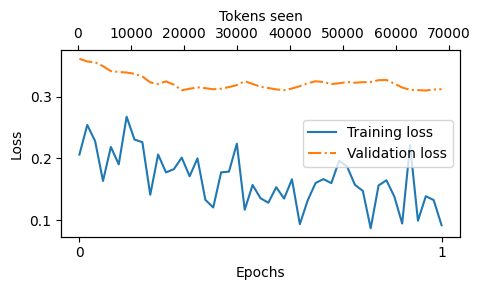

In [137]:
epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

- As we can see above, the loss continues to improve, which is a good sign
- Based on the downward slope, one might be tempted to train the model a bit further (and readers are encouraged to try this), but note that DPO is prone to collapse, where the model may start generating nonsensical responses
- Next, let's take a look at the reward margins:

### Reward Margins

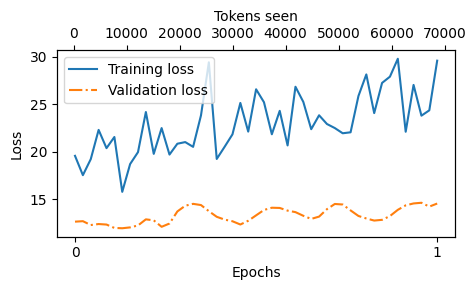

In [138]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="loss"
)

- As we can see, and as it's desired, the reward margins improve; this mirrors the loss curve and is a good sign
- Note that DPO losses and reward margins are valuable metrics to track during training; however, they don't tell the whole story
- Lastly, and most importantly, we have to conduct a qualitative check of the responses
- Here, we will look at the response (in addition, you could use an LLM to score the responses similar to chapter 7)

### Qualitative checks

In [139]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Reference model response:
>> The meal is cooked every day by the chef.

Policy model response:
>> 

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Reference model response:
>> Dance is a verb.

Policy model response:
>> 

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>>

In [147]:
in1 = text_to_token_ids(input_text, tokenizer).to(device)
out1 = policy_model(in1)
out1r = reference_model(in1)

In [146]:
in1.shape

torch.Size([1, 44])

In [145]:
out1.shape

torch.Size([1, 44, 50257])

In [148]:
out1r.shape

torch.Size([1, 44, 50257])

In [149]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a bullet.

Policy model response:
>> 

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Policy model response:
>> 

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Cor